In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


california = fetch_california_housing(as_frame=True)
data = pd.DataFrame(california.data, columns=california.feature_names)
data['MedHouseVal'] = california.target

features = ['MedInc', 'AveOccup', 'HouseAge']
X = torch.tensor(data[features].values, dtype=torch.float)
y = torch.tensor(data['MedHouseVal'].values, dtype=torch.float)

def model(X, y):

    num_features = X.shape[1]

    Intercept = pyro.sample("Intercept", dist.Gamma(1, 1))
    slope = pyro.sample("slope", dist.Gamma(torch.ones(num_features), 1))

    mean = Intercept + torch.matmul(X, slope)

    sigma = pyro.sample("sigma", dist.Gamma(1, 1))

    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

pyro.clear_param_store()

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mcmc.run(X_train, y_train)

posterior_samples = mcmc.get_samples()

posterior_intercept = posterior_samples['Intercept']
posterior_slope = posterior_samples['slope']
posterior_sigma = posterior_samples['sigma']


Sample: 100%|██████████| 1200/1200 [02:03,  9.75it/s, step size=2.56e-01, acc. prob=0.928]


In [ ]:
from sklearn.metrics import r2_score

mean_alpha = posterior_intercept.mean().item()
mean_beta = posterior_slope.mean(dim=0).numpy()
mean_sigma = posterior_sigma.mean().item()

predicted_values = mean_alpha + X_test.numpy() @ mean_beta

r_squared = r2_score(y_test.numpy(), predicted_values)
print(f'R-squared (R²) on the test set: {r_squared:.2f}')

R-squared (R²) on the test set: 0.49


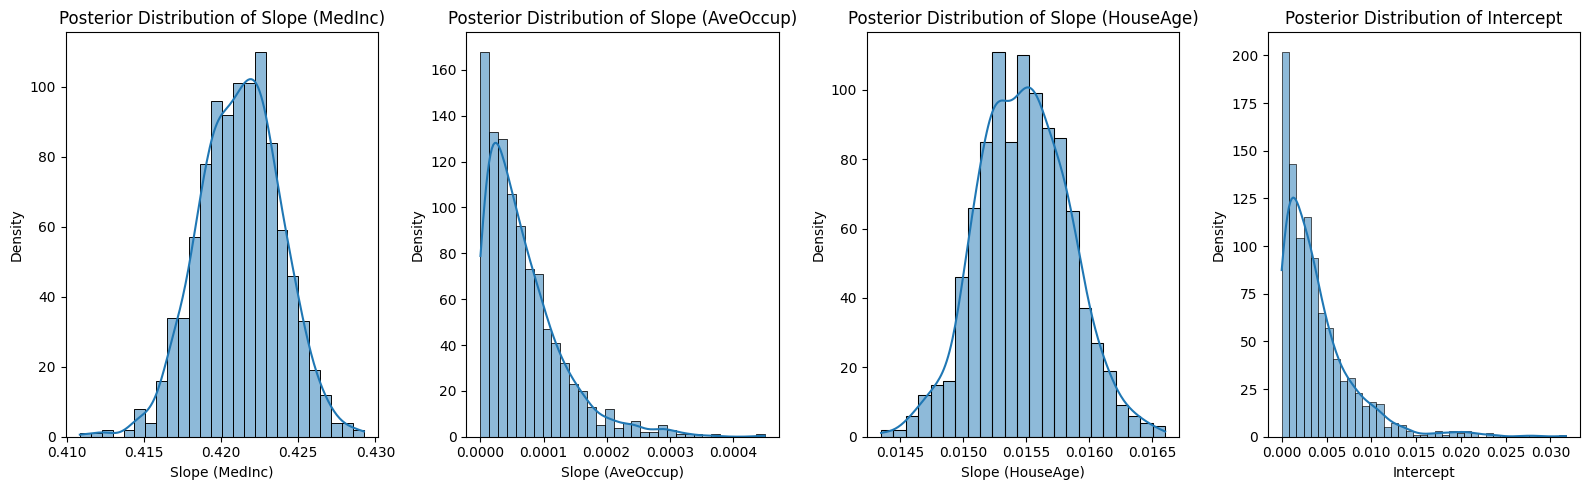

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_features = posterior_slope.shape[1]

fig, axes = plt.subplots(1, num_features + 1, figsize=(16, 5))

for i in range(num_features):
    sns.histplot(posterior_slope[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'Posterior Distribution of Slope ({features[i]})')
    axes[i].set_xlabel(f'Slope ({features[i]})')
    axes[i].set_ylabel('Density')

sns.histplot(posterior_intercept, kde=True, ax=axes[num_features])
axes[num_features].set_title('Posterior Distribution of Intercept')
axes[num_features].set_xlabel('Intercept')
axes[num_features].set_ylabel('Density')

plt.tight_layout()
plt.show()


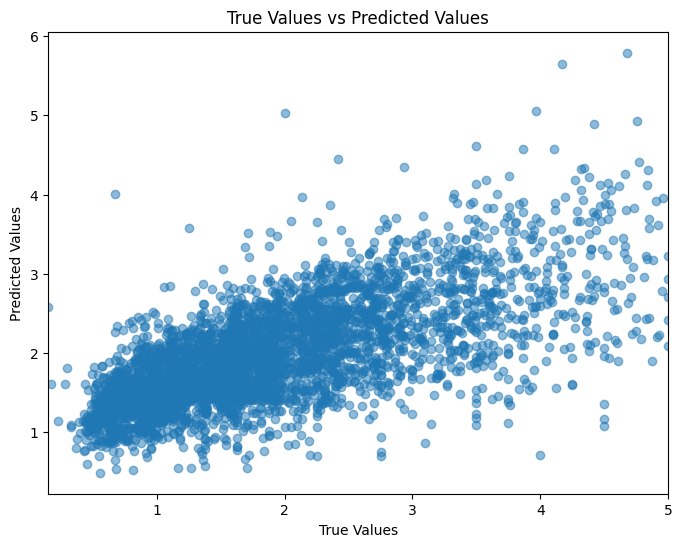

In [ ]:
plt.figure(figsize=(8, 6))

mask = y_test.numpy() <= 5
plt.scatter(y_test.numpy()[mask], predicted_values[mask], alpha=0.5)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs Predicted Values')

x_axis_range = 5
plt.xlim(min(y_test.numpy()) - 0, max(y_test.numpy()))

plt.show()
